## Predicting Red Wine Quality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy.stats.stats import pearsonr
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from graphviz import Source
from sklearn.tree import export_graphviz
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
#from adspy_shared_utilities import plot_class_regions_for_classifier

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow import keras

#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)


def Average(lst): 
    return sum(lst) / len(lst) 

In [3]:
def decisionTree_(X_train, X_test, y_train, y_test, Criterion_, max_depth_):
    decisionTree = DecisionTreeClassifier(criterion = Criterion_, max_depth=max_depth_); #max_depth=10, criterion="gini", random_state=42);
    decisionTree.fit(X_train, y_train)
    return decisionTree

In [4]:
def KNNClassifier(X_train, X_test, y_train, y_test, NumNeigbors):
    KNNClassifier = KNeighborsClassifier(n_neighbors = NumNeigbors)
    KNNClassifier.fit(X_train, y_train)
    return KNNClassifier

In [5]:
def NaiveBayesClassifier(X_train, X_test, y_train, y_test):
    NBClassifier = GaussianNB().fit(X_train, y_train)
    return NBClassifier

In [6]:
def NeuralNetworkClassifier(X_train, X_test, y_train, y_test):
    NN_Clf = keras.models.Sequential([
                keras.layers.Dense(17, activation = 'tanh', input_shape=(11,)), 
                keras.layers.Dense(1, activation = 'sigmoid')])
        
    NN_Clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    NN_Clf.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)
    NN_Clf.evaluate(X_test, y_test,verbose=1)
    return NN_Clf

In [7]:
wineRed = pd.read_csv('./processeddata/RedWine.csv', skipinitialspace=True, index_col=0)

wineRed = wineRed.loc[:, wineRed.columns != "Categorical Quality"]
wineRed['Categorical Quality'] = wineRed['quality']
cleanup_nums = {"Categorical Quality": {3: "Low", 4:"Low" , 5: "Low", 6: "High",
                                  7: "High", 8: "High", 9:"High"}}
wineRed = wineRed.replace(cleanup_nums)
cleanup_nums = {"Categorical Quality": {"Low": 0, "High":1}}
wineRed = wineRed.replace(cleanup_nums)

X_wineRed_help = wineRed.loc[:, wineRed.columns != "Categorical Quality"]
X_wineRed = X_wineRed_help.loc[:, X_wineRed_help.columns != "quality"]
y_wineRed = wineRed["Categorical Quality"]

X_trainRed, X_testRed, y_trainRed, y_testRed = train_test_split(X_wineRed, y_wineRed, test_size=0.2, random_state=42)

# Define the scaler 
scaler = StandardScaler().fit(X_trainRed)
X_trainRed = scaler.transform(X_trainRed)
X_testRed = scaler.transform(X_testRed)

y_trainRed = y_trainRed.to_numpy()
y_testRed = y_testRed.to_numpy()

### DBSCAN

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_dbscan"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [9]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [10]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [11]:
from sklearn.cluster import DBSCAN

In [13]:
dbscan = DBSCAN(eps=0.00005, min_samples=10)
dbscan.fit(X_trainRed)

DBSCAN(eps=5e-05, min_samples=10)

In [16]:
dbscan2 = DBSCAN(eps=2, min_samples=10)
dbscan2.fit(X_trainRed)

DBSCAN(eps=2, min_samples=10)

Saving figure dbscan_plot


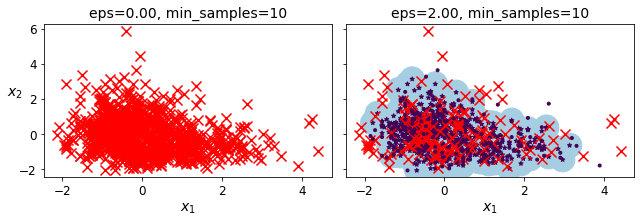

In [17]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X_trainRed, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X_trainRed, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

In [18]:
dbscan = dbscan2

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=20)

In [25]:
X_new = X_testRed
knn.predict(X_new)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
knn.predict_proba(X_new)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [27]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

### Comparing Models

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

categorical_names_red = wineRed["Categorical Quality"].unique()

report_DT_E = []
report_DT_G = []
report_KNN = []
report_NB = []
report_NN = []

report_DT_E_Train = []
report_DT_G_Train = []
report_KNN_Train = []
report_NB_Train = []
report_NN_Train = []

accuracy_DT_E = []
accuracy_DT_G = []
accuracy_KNN = []
accuracy_NB = []
accuracy_NN = []

accuracy_DT_E_Train = []
accuracy_DT_G_Train = []
accuracy_KNN_Train = []
accuracy_NB_Train = []
accuracy_NN_Train = []


AverageTesting = []
AverageUnit = []

# AverageTraining = []
# AverageUnitTraining = []

kf = KFold(n_splits=10, random_state=None, shuffle=True)

i = 0
for train_index, test_index in kf.split(X_trainRed):

    X_train, X_test_val = X_trainRed[train_index], X_trainRed[test_index]
    y_train, y_test_val = y_trainRed[train_index], y_trainRed[test_index]
    
    DT_Entropy_Clf = decisionTree_(X_train, X_test_val, y_train, y_test_val, "entropy", 3)
    DT_Gini_Clf = decisionTree_(X_train, X_test_val, y_train, y_test_val, "gini", 3)
    KNN_Clf = KNNClassifier(X_train, X_test_val, y_train, y_test_val, 50)
    NB_Clf = NaiveBayesClassifier(X_train, X_test_val, y_train, y_test_val)
    NN_Clf = NeuralNetworkClassifier(X_train, X_test_val, y_train, y_test_val)
    
    y_predict_DT_E = DT_Entropy_Clf.predict(X_test_val)
    y_predict_DT_G = DT_Entropy_Clf.predict(X_test_val)
    y_predict_KNN = KNN_Clf.predict(X_test_val)
    y_predict_NB = NB_Clf.predict(X_test_val)
    y_predict_NN = NN_Clf.predict(X_test_val)
    
    y_predict_DT_E_Train = DT_Entropy_Clf.predict(X_train)
    y_predict_DT_G_Train = DT_Entropy_Clf.predict(X_train)
    y_predict_KNN_Train = KNN_Clf.predict(X_train)
    y_predict_NB_Train = NB_Clf.predict(X_train)
    y_predict_NN_Train = NN_Clf.predict(X_train)
    
    report_DT_E.append(classification_report(y_test_val, y_predict_DT_E, output_dict=True))
    report_DT_G.append(classification_report(y_test_val, y_predict_DT_G, output_dict=True))
    report_KNN.append(classification_report(y_test_val, y_predict_KNN, output_dict=True))    
    report_NB.append(classification_report(y_test_val, y_predict_NB, output_dict=True))
    AverageTesting.append(NN_Clf.evaluate(X_test_val, y_test_val,verbose=1))
    AverageUnit.append(Average(NN_Clf.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1).history['accuracy']))
    
    report_DT_E_Train.append(classification_report(y_train, y_predict_DT_E_Train, output_dict=True))
    report_DT_G_Train.append(classification_report(y_train, y_predict_DT_G_Train, output_dict=True))
    report_KNN_Train.append(classification_report(y_train, y_predict_KNN_Train, output_dict=True))    
    report_NB_Train.append(classification_report(y_train, y_predict_NB_Train, output_dict=True))
#     AverageTraining.append(NN_Clf.evaluate(X_train, y_test_val,verbose=1))
#     AverageUnitTraining.append(Average(NN_Clf.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1).history['accuracy']))
      
    accuracy_DT_E.append(report_DT_E[i]["accuracy"])
    accuracy_DT_G.append(report_DT_G[i]["accuracy"])
    accuracy_KNN.append(report_KNN[i]["accuracy"])
    accuracy_NB.append(report_NB[i]["accuracy"])
    
    accuracy_DT_E_Train.append(report_DT_E_Train[i]["accuracy"])
    accuracy_DT_G_Train.append(report_DT_G_Train[i]["accuracy"])
    accuracy_KNN_Train.append(report_KNN_Train[i]["accuracy"])
    accuracy_NB_Train.append(report_NB_Train[i]["accuracy"])
    
    i = i + 1
    

Train on 978 samples
Epoch 1/100
978/978 [==============================] - 1s 1ms/sample - loss: 0.7073 - accuracy: 0.5378
Epoch 2/100
978/978 [==============================] - 0s 147us/sample - loss: 0.5747 - accuracy: 0.7290
Epoch 3/100
978/978 [==============================] - 0s 150us/sample - loss: 0.5429 - accuracy: 0.7290
Epoch 4/100
978/978 [==============================] - 0s 147us/sample - loss: 0.5332 - accuracy: 0.7270
Epoch 5/100
978/978 [==============================] - 0s 147us/sample - loss: 0.5281 - accuracy: 0.7290
Epoch 6/100
978/978 [==============================] - 0s 148us/sample - loss: 0.5258 - accuracy: 0.7301
Epoch 7/100
978/978 [==============================] - 0s 145us/sample - loss: 0.5229 - accuracy: 0.7331
Epoch 8/100
978/978 [==============================] - 0s 145us/sample - loss: 0.5216 - accuracy: 0.7301
Epoch 9/100
978/978 [==============================] - 0s 150us/sample - loss: 0.5199 - accuracy: 0.7321
Epoch 10/100
978/978 [==============

978/978 [==============================] - 0s 148us/sample - loss: 0.4555 - accuracy: 0.7791
Epoch 79/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4546 - accuracy: 0.7853
Epoch 80/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4549 - accuracy: 0.7853
Epoch 81/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4531 - accuracy: 0.7812
Epoch 82/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4526 - accuracy: 0.7853
Epoch 83/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4521 - accuracy: 0.7822
Epoch 84/100
978/978 [==============================] - 0s 152us/sample - loss: 0.4515 - accuracy: 0.7853
Epoch 85/100
978/978 [==============================] - 0s 144us/sample - loss: 0.4509 - accuracy: 0.7873
Epoch 86/100
978/978 [==============================] - 0s 141us/sample - loss: 0.4500 - accuracy: 0.7873
Epoch 87/100
978/978 [==============================] - 0s 

Train on 978 samples
Epoch 1/100
978/978 [==============================] - 0s 179us/sample - loss: 0.4419 - accuracy: 0.7873
Epoch 2/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4407 - accuracy: 0.7935
Epoch 3/100
978/978 [==============================] - 0s 152us/sample - loss: 0.4420 - accuracy: 0.7914
Epoch 4/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4398 - accuracy: 0.7924
Epoch 5/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4395 - accuracy: 0.7935
Epoch 6/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4398 - accuracy: 0.7832
Epoch 7/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4391 - accuracy: 0.7873
Epoch 8/100
978/978 [==============================] - 0s 138us/sample - loss: 0.4379 - accuracy: 0.7914
Epoch 9/100
978/978 [==============================] - 0s 138us/sample - loss: 0.4376 - accuracy: 0.7873
Epoch 10/100
978/978 [============

978/978 [==============================] - 0s 146us/sample - loss: 0.4044 - accuracy: 0.8108
Epoch 79/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4044 - accuracy: 0.8129
Epoch 80/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4041 - accuracy: 0.8078
Epoch 81/100
978/978 [==============================] - 0s 164us/sample - loss: 0.4031 - accuracy: 0.8129
Epoch 82/100
978/978 [==============================] - 0s 176us/sample - loss: 0.4027 - accuracy: 0.8037
Epoch 83/100
978/978 [==============================] - 0s 164us/sample - loss: 0.4025 - accuracy: 0.8119
Epoch 84/100
978/978 [==============================] - 0s 164us/sample - loss: 0.4025 - accuracy: 0.8119
Epoch 85/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4010 - accuracy: 0.8098
Epoch 86/100
978/978 [==============================] - 0s 159us/sample - loss: 0.4013 - accuracy: 0.8129
Epoch 87/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 145us/sample - loss: 0.4819 - accuracy: 0.7699
Epoch 56/100
978/978 [==============================] - 0s 142us/sample - loss: 0.4809 - accuracy: 0.7648
Epoch 57/100
978/978 [==============================] - 0s 145us/sample - loss: 0.4797 - accuracy: 0.7648
Epoch 58/100
978/978 [==============================] - 0s 151us/sample - loss: 0.4790 - accuracy: 0.7658
Epoch 59/100
978/978 [==============================] - 0s 145us/sample - loss: 0.4789 - accuracy: 0.7689
Epoch 60/100
978/978 [==============================] - 0s 144us/sample - loss: 0.4784 - accuracy: 0.7699
Epoch 61/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4774 - accuracy: 0.7699
Epoch 62/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4760 - accuracy: 0.7730
Epoch 63/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4760 - accuracy: 0.7648
Epoch 64/100
978/978 [==============================] - 0s 

109/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

978/978 [==============================] - 0s 152us/sample - loss: 0.4321 - accuracy: 0.7832
Epoch 47/100
978/978 [==============================] - 0s 138us/sample - loss: 0.4311 - accuracy: 0.7904
Epoch 48/100
978/978 [==============================] - 0s 154us/sample - loss: 0.4299 - accuracy: 0.7873
Epoch 49/100
978/978 [==============================] - 0s 151us/sample - loss: 0.4299 - accuracy: 0.7965
Epoch 50/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4294 - accuracy: 0.7894
Epoch 51/100
978/978 [==============================] - 0s 145us/sample - loss: 0.4288 - accuracy: 0.7904
Epoch 52/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4283 - accuracy: 0.7894
Epoch 53/100
978/978 [==============================] - 0s 152us/sample - loss: 0.4279 - accuracy: 0.7965
Epoch 54/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4281 - accuracy: 0.7904
Epoch 55/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 151us/sample - loss: 0.5058 - accuracy: 0.7556
Epoch 24/100
978/978 [==============================] - 0s 158us/sample - loss: 0.5049 - accuracy: 0.7536
Epoch 25/100
978/978 [==============================] - 0s 159us/sample - loss: 0.5040 - accuracy: 0.7536
Epoch 26/100
978/978 [==============================] - 0s 173us/sample - loss: 0.5022 - accuracy: 0.7495
Epoch 27/100
978/978 [==============================] - 0s 163us/sample - loss: 0.5013 - accuracy: 0.7454
Epoch 28/100
978/978 [==============================] - 0s 185us/sample - loss: 0.5006 - accuracy: 0.7566
Epoch 29/100
978/978 [==============================] - 0s 189us/sample - loss: 0.4999 - accuracy: 0.7556
Epoch 30/100
978/978 [==============================] - 0s 211us/sample - loss: 0.4986 - accuracy: 0.7515
Epoch 31/100
978/978 [==============================] - 0s 199us/sample - loss: 0.4972 - accuracy: 0.7546
Epoch 32/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 191us/sample - loss: 0.4427 - accuracy: 0.7822
109/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

978/978 [==============================] - 0s 182us/sample - loss: 0.4345 - accuracy: 0.7935
Epoch 15/100
978/978 [==============================] - 0s 193us/sample - loss: 0.4343 - accuracy: 0.7873
Epoch 16/100
978/978 [==============================] - 0s 191us/sample - loss: 0.4338 - accuracy: 0.7935
Epoch 17/100
978/978 [==============================] - 0s 190us/sample - loss: 0.4323 - accuracy: 0.7975
Epoch 18/100
978/978 [==============================] - 0s 193us/sample - loss: 0.4328 - accuracy: 0.7935
Epoch 19/100
978/978 [==============================] - 0s 178us/sample - loss: 0.4324 - accuracy: 0.7945
Epoch 20/100
978/978 [==============================] - 0s 188us/sample - loss: 0.4308 - accuracy: 0.7924
Epoch 21/100
978/978 [==============================] - 0s 190us/sample - loss: 0.4311 - accuracy: 0.7945
Epoch 22/100
978/978 [==============================] - 0s 185us/sample - loss: 0.4308 - accuracy: 0.7965
Epoch 23/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 165us/sample - loss: 0.4008 - accuracy: 0.8119
Epoch 92/100
978/978 [==============================] - 0s 170us/sample - loss: 0.3985 - accuracy: 0.8139
Epoch 93/100
978/978 [==============================] - 0s 159us/sample - loss: 0.3991 - accuracy: 0.8139
Epoch 94/100
978/978 [==============================] - 0s 163us/sample - loss: 0.3984 - accuracy: 0.8139
Epoch 95/100
978/978 [==============================] - 0s 168us/sample - loss: 0.3982 - accuracy: 0.8160
Epoch 96/100
978/978 [==============================] - 0s 157us/sample - loss: 0.3980 - accuracy: 0.8149
Epoch 97/100
978/978 [==============================] - 0s 158us/sample - loss: 0.3980 - accuracy: 0.8160
Epoch 98/100
978/978 [==============================] - 0s 160us/sample - loss: 0.3976 - accuracy: 0.8108
Epoch 99/100
978/978 [==============================] - 0s 158us/sample - loss: 0.3966 - accuracy: 0.8139
Epoch 100/100
978/978 [==============================] - 0s

978/978 [==============================] - 0s 159us/sample - loss: 0.4546 - accuracy: 0.7853
Epoch 69/100
978/978 [==============================] - 0s 157us/sample - loss: 0.4533 - accuracy: 0.7802
Epoch 70/100
978/978 [==============================] - 0s 160us/sample - loss: 0.4535 - accuracy: 0.7853
Epoch 71/100
978/978 [==============================] - 0s 159us/sample - loss: 0.4525 - accuracy: 0.7883
Epoch 72/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4506 - accuracy: 0.7832
Epoch 73/100
978/978 [==============================] - 0s 159us/sample - loss: 0.4509 - accuracy: 0.7843
Epoch 74/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4505 - accuracy: 0.7894
Epoch 75/100
978/978 [==============================] - 0s 155us/sample - loss: 0.4484 - accuracy: 0.7914
Epoch 76/100
978/978 [==============================] - 0s 165us/sample - loss: 0.4481 - accuracy: 0.7853
Epoch 77/100
978/978 [==============================] - 0s 

Train on 978 samples
Epoch 1/100
978/978 [==============================] - 0s 182us/sample - loss: 0.4325 - accuracy: 0.7986
Epoch 2/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4313 - accuracy: 0.7904
Epoch 3/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4317 - accuracy: 0.8016
Epoch 4/100
978/978 [==============================] - 0s 151us/sample - loss: 0.4304 - accuracy: 0.7996
Epoch 5/100
978/978 [==============================] - 0s 144us/sample - loss: 0.4297 - accuracy: 0.8006
Epoch 6/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4296 - accuracy: 0.7945
Epoch 7/100
978/978 [==============================] - 0s 141us/sample - loss: 0.4295 - accuracy: 0.7986
Epoch 8/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4285 - accuracy: 0.7986
Epoch 9/100
978/978 [==============================] - 0s 161us/sample - loss: 0.4280 - accuracy: 0.8037
Epoch 10/100
978/978 [============

978/978 [==============================] - 0s 159us/sample - loss: 0.3930 - accuracy: 0.8200
Epoch 79/100
978/978 [==============================] - 0s 156us/sample - loss: 0.3924 - accuracy: 0.8180
Epoch 80/100
978/978 [==============================] - 0s 159us/sample - loss: 0.3923 - accuracy: 0.8170
Epoch 81/100
978/978 [==============================] - 0s 158us/sample - loss: 0.3916 - accuracy: 0.8190
Epoch 82/100
978/978 [==============================] - 0s 158us/sample - loss: 0.3911 - accuracy: 0.8149
Epoch 83/100
978/978 [==============================] - 0s 163us/sample - loss: 0.3923 - accuracy: 0.8139
Epoch 84/100
978/978 [==============================] - 0s 154us/sample - loss: 0.3908 - accuracy: 0.8221
Epoch 85/100
978/978 [==============================] - 0s 160us/sample - loss: 0.3906 - accuracy: 0.8190
Epoch 86/100
978/978 [==============================] - 0s 160us/sample - loss: 0.3902 - accuracy: 0.8180
Epoch 87/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 153us/sample - loss: 0.4813 - accuracy: 0.7556
Epoch 56/100
978/978 [==============================] - 0s 156us/sample - loss: 0.4791 - accuracy: 0.7618
Epoch 57/100
978/978 [==============================] - 0s 160us/sample - loss: 0.4796 - accuracy: 0.7577
Epoch 58/100
978/978 [==============================] - 0s 161us/sample - loss: 0.4776 - accuracy: 0.7628
Epoch 59/100
978/978 [==============================] - 0s 156us/sample - loss: 0.4766 - accuracy: 0.7577
Epoch 60/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4764 - accuracy: 0.7638
Epoch 61/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4751 - accuracy: 0.7597
Epoch 62/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4750 - accuracy: 0.7618
Epoch 63/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4740 - accuracy: 0.7607
Epoch 64/100
978/978 [==============================] - 0s 

109/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

978/978 [==============================] - 0s 151us/sample - loss: 0.4177 - accuracy: 0.8047
Epoch 47/100
978/978 [==============================] - 0s 151us/sample - loss: 0.4168 - accuracy: 0.8108
Epoch 48/100
978/978 [==============================] - 0s 156us/sample - loss: 0.4167 - accuracy: 0.8119
Epoch 49/100
978/978 [==============================] - 0s 163us/sample - loss: 0.4165 - accuracy: 0.8108
Epoch 50/100
978/978 [==============================] - 0s 149us/sample - loss: 0.4157 - accuracy: 0.8108
Epoch 51/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4150 - accuracy: 0.8098
Epoch 52/100
978/978 [==============================] - 0s 156us/sample - loss: 0.4144 - accuracy: 0.8098
Epoch 53/100
978/978 [==============================] - 0s 152us/sample - loss: 0.4146 - accuracy: 0.8119
Epoch 54/100
978/978 [==============================] - 0s 155us/sample - loss: 0.4137 - accuracy: 0.8098
Epoch 55/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 161us/sample - loss: 0.5089 - accuracy: 0.7515
Epoch 24/100
978/978 [==============================] - 0s 157us/sample - loss: 0.5066 - accuracy: 0.7434
Epoch 25/100
978/978 [==============================] - 0s 168us/sample - loss: 0.5061 - accuracy: 0.7423
Epoch 26/100
978/978 [==============================] - 0s 164us/sample - loss: 0.5049 - accuracy: 0.7444
Epoch 27/100
978/978 [==============================] - 0s 158us/sample - loss: 0.5038 - accuracy: 0.7505
Epoch 28/100
978/978 [==============================] - 0s 170us/sample - loss: 0.5034 - accuracy: 0.7485
Epoch 29/100
978/978 [==============================] - 0s 155us/sample - loss: 0.5026 - accuracy: 0.7566
Epoch 30/100
978/978 [==============================] - 0s 152us/sample - loss: 0.5018 - accuracy: 0.7515
Epoch 31/100
978/978 [==============================] - 0s 151us/sample - loss: 0.5012 - accuracy: 0.7546
Epoch 32/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 157us/sample - loss: 0.4412 - accuracy: 0.7924
109/1 [====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

978/978 [==============================] - 0s 162us/sample - loss: 0.4309 - accuracy: 0.7945
Epoch 15/100
978/978 [==============================] - 0s 155us/sample - loss: 0.4317 - accuracy: 0.7904
Epoch 16/100
978/978 [==============================] - 0s 156us/sample - loss: 0.4301 - accuracy: 0.7996
Epoch 17/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4293 - accuracy: 0.8027
Epoch 18/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4286 - accuracy: 0.8027
Epoch 19/100
978/978 [==============================] - 0s 152us/sample - loss: 0.4278 - accuracy: 0.8037
Epoch 20/100
978/978 [==============================] - 0s 158us/sample - loss: 0.4272 - accuracy: 0.8067
Epoch 21/100
978/978 [==============================] - 0s 153us/sample - loss: 0.4264 - accuracy: 0.8027
Epoch 22/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4259 - accuracy: 0.7945
Epoch 23/100
978/978 [==============================] - 0s 

978/978 [==============================] - 0s 156us/sample - loss: 0.3852 - accuracy: 0.8303
Epoch 92/100
978/978 [==============================] - 0s 155us/sample - loss: 0.3847 - accuracy: 0.8323
Epoch 93/100
978/978 [==============================] - 0s 152us/sample - loss: 0.3837 - accuracy: 0.8313
Epoch 94/100
978/978 [==============================] - 0s 156us/sample - loss: 0.3837 - accuracy: 0.8272
Epoch 95/100
978/978 [==============================] - 0s 156us/sample - loss: 0.3842 - accuracy: 0.8292
Epoch 96/100
978/978 [==============================] - 0s 156us/sample - loss: 0.3828 - accuracy: 0.8333
Epoch 97/100
978/978 [==============================] - 0s 166us/sample - loss: 0.3833 - accuracy: 0.8272
Epoch 98/100
978/978 [==============================] - 0s 146us/sample - loss: 0.3817 - accuracy: 0.8313
Epoch 99/100
978/978 [==============================] - 0s 152us/sample - loss: 0.3810 - accuracy: 0.8323
Epoch 100/100
978/978 [==============================] - 0s

978/978 [==============================] - 0s 155us/sample - loss: 0.4430 - accuracy: 0.7802
Epoch 69/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4430 - accuracy: 0.7771
Epoch 70/100
978/978 [==============================] - 0s 144us/sample - loss: 0.4424 - accuracy: 0.7863
Epoch 71/100
978/978 [==============================] - 0s 142us/sample - loss: 0.4404 - accuracy: 0.7853
Epoch 72/100
978/978 [==============================] - 0s 146us/sample - loss: 0.4397 - accuracy: 0.7822
Epoch 73/100
978/978 [==============================] - 0s 143us/sample - loss: 0.4391 - accuracy: 0.7853
Epoch 74/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4381 - accuracy: 0.7873
Epoch 75/100
978/978 [==============================] - 0s 147us/sample - loss: 0.4370 - accuracy: 0.7904
Epoch 76/100
978/978 [==============================] - 0s 154us/sample - loss: 0.4367 - accuracy: 0.7832
Epoch 77/100
978/978 [==============================] - 0s 

Train on 978 samples
Epoch 1/100
978/978 [==============================] - 0s 178us/sample - loss: 0.4180 - accuracy: 0.8027
Epoch 2/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4170 - accuracy: 0.8006
Epoch 3/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4166 - accuracy: 0.8098
Epoch 4/100
978/978 [==============================] - 0s 148us/sample - loss: 0.4166 - accuracy: 0.8016
Epoch 5/100
978/978 [==============================] - 0s 151us/sample - loss: 0.4158 - accuracy: 0.8016
Epoch 6/100
978/978 [==============================] - 0s 163us/sample - loss: 0.4142 - accuracy: 0.8078
Epoch 7/100
978/978 [==============================] - 0s 165us/sample - loss: 0.4144 - accuracy: 0.8057
Epoch 8/100
978/978 [==============================] - 0s 162us/sample - loss: 0.4129 - accuracy: 0.8057
Epoch 9/100
978/978 [==============================] - 0s 150us/sample - loss: 0.4125 - accuracy: 0.8129
Epoch 10/100
978/978 [============

978/978 [==============================] - 0s 153us/sample - loss: 0.3756 - accuracy: 0.8405
Epoch 79/100
978/978 [==============================] - 0s 161us/sample - loss: 0.3749 - accuracy: 0.8395
Epoch 80/100
978/978 [==============================] - 0s 154us/sample - loss: 0.3755 - accuracy: 0.8364
Epoch 81/100
978/978 [==============================] - 0s 150us/sample - loss: 0.3745 - accuracy: 0.8333
Epoch 82/100
978/978 [==============================] - 0s 155us/sample - loss: 0.3732 - accuracy: 0.8344
Epoch 83/100
978/978 [==============================] - 0s 152us/sample - loss: 0.3727 - accuracy: 0.8364
Epoch 84/100
978/978 [==============================] - 0s 151us/sample - loss: 0.3730 - accuracy: 0.8333
Epoch 85/100
978/978 [==============================] - 0s 164us/sample - loss: 0.3726 - accuracy: 0.8374
Epoch 86/100
978/978 [==============================] - 0s 151us/sample - loss: 0.3725 - accuracy: 0.8354
Epoch 87/100
978/978 [==============================] - 0s 

979/979 [==============================] - 0s 151us/sample - loss: 0.4724 - accuracy: 0.7732
Epoch 56/100
979/979 [==============================] - 0s 158us/sample - loss: 0.4708 - accuracy: 0.7722
Epoch 57/100
979/979 [==============================] - 0s 154us/sample - loss: 0.4700 - accuracy: 0.7722
Epoch 58/100
979/979 [==============================] - 0s 157us/sample - loss: 0.4702 - accuracy: 0.7661
Epoch 59/100
979/979 [==============================] - 0s 154us/sample - loss: 0.4684 - accuracy: 0.7743
Epoch 60/100
979/979 [==============================] - 0s 151us/sample - loss: 0.4683 - accuracy: 0.7712
Epoch 61/100
979/979 [==============================] - 0s 157us/sample - loss: 0.4661 - accuracy: 0.7712
Epoch 62/100
979/979 [==============================] - 0s 155us/sample - loss: 0.4660 - accuracy: 0.7712
Epoch 63/100
979/979 [==============================] - 0s 158us/sample - loss: 0.4652 - accuracy: 0.7753
Epoch 64/100
979/979 [==============================] - 0s 

Train on 979 samples
Epoch 1/100
979/979 [==============================] - 0s 176us/sample - loss: 0.4396 - accuracy: 0.7824
Epoch 2/100
979/979 [==============================] - 0s 156us/sample - loss: 0.4377 - accuracy: 0.7896
Epoch 3/100
979/979 [==============================] - 0s 145us/sample - loss: 0.4371 - accuracy: 0.7855
Epoch 4/100
979/979 [==============================] - 0s 148us/sample - loss: 0.4371 - accuracy: 0.7845
Epoch 5/100
979/979 [==============================] - 0s 152us/sample - loss: 0.4368 - accuracy: 0.7824
Epoch 6/100
979/979 [==============================] - 0s 157us/sample - loss: 0.4353 - accuracy: 0.7835
Epoch 7/100
979/979 [==============================] - 0s 158us/sample - loss: 0.4355 - accuracy: 0.7865
Epoch 8/100
979/979 [==============================] - 0s 150us/sample - loss: 0.4340 - accuracy: 0.7865
Epoch 9/100
979/979 [==============================] - 0s 154us/sample - loss: 0.4338 - accuracy: 0.7865
Epoch 10/100
979/979 [============

979/979 [==============================] - 0s 145us/sample - loss: 0.4004 - accuracy: 0.8131
Epoch 79/100
979/979 [==============================] - 0s 199us/sample - loss: 0.4000 - accuracy: 0.8121
Epoch 80/100
979/979 [==============================] - 0s 182us/sample - loss: 0.3991 - accuracy: 0.8172
Epoch 81/100
979/979 [==============================] - 0s 258us/sample - loss: 0.3997 - accuracy: 0.8131
Epoch 82/100
979/979 [==============================] - 0s 208us/sample - loss: 0.3970 - accuracy: 0.8141
Epoch 83/100
979/979 [==============================] - 0s 176us/sample - loss: 0.3988 - accuracy: 0.8080
Epoch 84/100
979/979 [==============================] - 0s 154us/sample - loss: 0.3970 - accuracy: 0.8202
Epoch 85/100
979/979 [==============================] - 0s 148us/sample - loss: 0.3971 - accuracy: 0.8131
Epoch 86/100
979/979 [==============================] - 0s 149us/sample - loss: 0.3976 - accuracy: 0.8151
Epoch 87/100
979/979 [==============================] - 0s 

979/979 [==============================] - 0s 146us/sample - loss: 0.4714 - accuracy: 0.7773
Epoch 56/100
979/979 [==============================] - 0s 143us/sample - loss: 0.4713 - accuracy: 0.7732
Epoch 57/100
979/979 [==============================] - 0s 150us/sample - loss: 0.4697 - accuracy: 0.7773
Epoch 58/100
979/979 [==============================] - 0s 142us/sample - loss: 0.4694 - accuracy: 0.7712
Epoch 59/100
979/979 [==============================] - 0s 146us/sample - loss: 0.4680 - accuracy: 0.7763
Epoch 60/100
979/979 [==============================] - 0s 143us/sample - loss: 0.4667 - accuracy: 0.7804
Epoch 61/100
979/979 [==============================] - 0s 147us/sample - loss: 0.4659 - accuracy: 0.7794
Epoch 62/100
979/979 [==============================] - 0s 142us/sample - loss: 0.4653 - accuracy: 0.7804
Epoch 63/100
979/979 [==============================] - 0s 143us/sample - loss: 0.4643 - accuracy: 0.7743
Epoch 64/100
979/979 [==============================] - 0s 

Train on 979 samples
Epoch 1/100
979/979 [==============================] - 0s 220us/sample - loss: 0.4369 - accuracy: 0.7937
Epoch 2/100
979/979 [==============================] - 0s 166us/sample - loss: 0.4356 - accuracy: 0.7926
Epoch 3/100
979/979 [==============================] - 0s 187us/sample - loss: 0.4359 - accuracy: 0.7926
Epoch 4/100
979/979 [==============================] - 0s 193us/sample - loss: 0.4348 - accuracy: 0.7967
Epoch 5/100
979/979 [==============================] - 0s 151us/sample - loss: 0.4350 - accuracy: 0.8018
Epoch 6/100
979/979 [==============================] - 0s 144us/sample - loss: 0.4337 - accuracy: 0.7937
Epoch 7/100
979/979 [==============================] - 0s 143us/sample - loss: 0.4332 - accuracy: 0.7906
Epoch 8/100
979/979 [==============================] - 0s 142us/sample - loss: 0.4326 - accuracy: 0.7967
Epoch 9/100
979/979 [==============================] - 0s 144us/sample - loss: 0.4320 - accuracy: 0.7967
Epoch 10/100
979/979 [============

979/979 [==============================] - 0s 149us/sample - loss: 0.3916 - accuracy: 0.8233
Epoch 79/100
979/979 [==============================] - 0s 145us/sample - loss: 0.3913 - accuracy: 0.8264
Epoch 80/100
979/979 [==============================] - 0s 142us/sample - loss: 0.3921 - accuracy: 0.8233
Epoch 81/100
979/979 [==============================] - 0s 146us/sample - loss: 0.3907 - accuracy: 0.8212
Epoch 82/100
979/979 [==============================] - 0s 147us/sample - loss: 0.3907 - accuracy: 0.8264
Epoch 83/100
979/979 [==============================] - 0s 142us/sample - loss: 0.3906 - accuracy: 0.8182
Epoch 84/100
979/979 [==============================] - 0s 144us/sample - loss: 0.3887 - accuracy: 0.8253
Epoch 85/100
979/979 [==============================] - 0s 142us/sample - loss: 0.3893 - accuracy: 0.8233
Epoch 86/100
979/979 [==============================] - 0s 141us/sample - loss: 0.3886 - accuracy: 0.8274
Epoch 87/100
979/979 [==============================] - 0s 

979/979 [==============================] - 0s 147us/sample - loss: 0.4729 - accuracy: 0.7722
Epoch 56/100
979/979 [==============================] - 0s 149us/sample - loss: 0.4721 - accuracy: 0.7681
Epoch 57/100
979/979 [==============================] - 0s 147us/sample - loss: 0.4717 - accuracy: 0.7661
Epoch 58/100
979/979 [==============================] - 0s 152us/sample - loss: 0.4715 - accuracy: 0.7671
Epoch 59/100
979/979 [==============================] - 0s 149us/sample - loss: 0.4712 - accuracy: 0.7692
Epoch 60/100
979/979 [==============================] - 0s 146us/sample - loss: 0.4702 - accuracy: 0.7753
Epoch 61/100
979/979 [==============================] - 0s 152us/sample - loss: 0.4691 - accuracy: 0.7681
Epoch 62/100
979/979 [==============================] - 0s 146us/sample - loss: 0.4683 - accuracy: 0.7712
Epoch 63/100
979/979 [==============================] - 0s 153us/sample - loss: 0.4686 - accuracy: 0.7732
Epoch 64/100
979/979 [==============================] - 0s 

Train on 979 samples
Epoch 1/100
979/979 [==============================] - 0s 182us/sample - loss: 0.4459 - accuracy: 0.7886
Epoch 2/100
979/979 [==============================] - 0s 143us/sample - loss: 0.4456 - accuracy: 0.7947
Epoch 3/100
979/979 [==============================] - 0s 142us/sample - loss: 0.4462 - accuracy: 0.7937
Epoch 4/100
979/979 [==============================] - 0s 151us/sample - loss: 0.4442 - accuracy: 0.7926
Epoch 5/100
979/979 [==============================] - 0s 147us/sample - loss: 0.4443 - accuracy: 0.7926
Epoch 6/100
979/979 [==============================] - 0s 144us/sample - loss: 0.4437 - accuracy: 0.7947
Epoch 7/100
979/979 [==============================] - 0s 148us/sample - loss: 0.4430 - accuracy: 0.7947
Epoch 8/100
979/979 [==============================] - 0s 144us/sample - loss: 0.4423 - accuracy: 0.7947
Epoch 9/100
979/979 [==============================] - 0s 155us/sample - loss: 0.4424 - accuracy: 0.7926
Epoch 10/100
979/979 [============

979/979 [==============================] - 0s 149us/sample - loss: 0.4097 - accuracy: 0.8161
Epoch 79/100
979/979 [==============================] - 0s 148us/sample - loss: 0.4096 - accuracy: 0.8141
Epoch 80/100
979/979 [==============================] - 0s 146us/sample - loss: 0.4092 - accuracy: 0.8141
Epoch 81/100
979/979 [==============================] - 0s 148us/sample - loss: 0.4088 - accuracy: 0.8192
Epoch 82/100
979/979 [==============================] - 0s 155us/sample - loss: 0.4089 - accuracy: 0.8141
Epoch 83/100
979/979 [==============================] - 0s 149us/sample - loss: 0.4084 - accuracy: 0.8141
Epoch 84/100
979/979 [==============================] - 0s 151us/sample - loss: 0.4081 - accuracy: 0.8172
Epoch 85/100
979/979 [==============================] - 0s 151us/sample - loss: 0.4071 - accuracy: 0.8233
Epoch 86/100
979/979 [==============================] - 0s 150us/sample - loss: 0.4072 - accuracy: 0.8192
Epoch 87/100
979/979 [==============================] - 0s 

In [29]:
#Neural Network Test
accuracies = []
for loss, accuracy in AverageTesting:
    accuracies.append(accuracy)
Average_accuracy = Average(accuracies)
print(Average_accuracy)

0.73787801861763


In [30]:
#Neural Network Train
units = []
for unit in AverageUnit:
    units.append(unit)
Average_unit = Average(units)
print(Average_unit)

0.8125325759053231


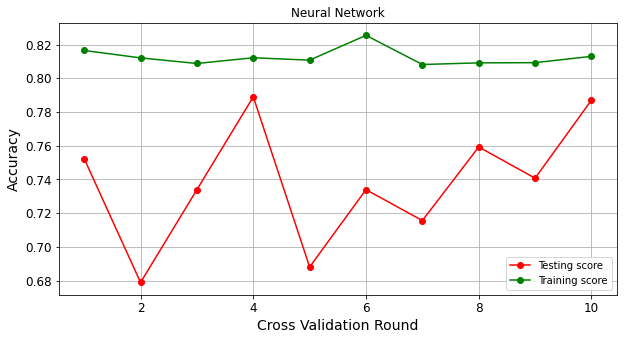

In [31]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
ax.set_title('Neural Network')
ax.set_xlabel("Cross Validation Round")
ax.set_ylabel("Accuracy")
ax.grid()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.plot(x, accuracies, 'o-', color="r", label="Testing score")
ax.plot(x, units, 'o-', color="g", label="Training score")
ax.legend(loc="best")

plt.show()

In [32]:
#Decision Tree Entropy 
print(Average(accuracy_DT_E))

0.6871899422358138


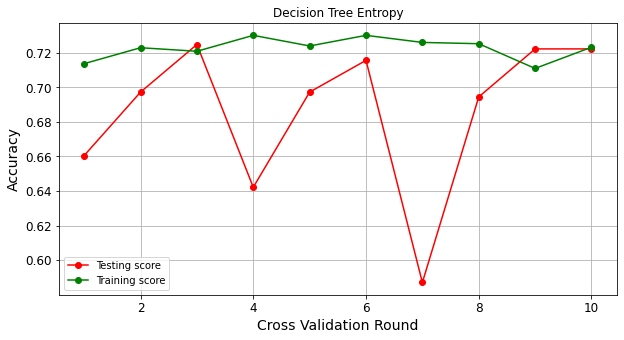

In [40]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
ax.set_title('Decision Tree Entropy')
ax.set_xlabel("Cross Validation Round")
ax.set_ylabel("Accuracy")
ax.grid()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.plot(x, accuracy_DT_E, 'o-', color="r", label="Testing score")
ax.plot(x, accuracy_DT_E_Train, 'o-', color="g", label="Training score")
ax.legend(loc="best")

plt.show()

In [41]:
#Decision Tree Gini
print(Average(accuracy_DT_G))

0.6863659531090724


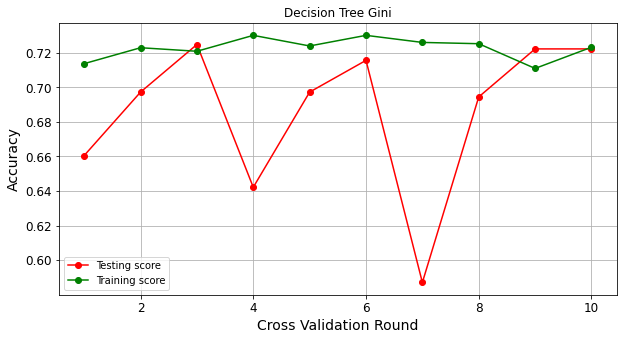

In [46]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
ax.set_title('Decision Tree Gini')
ax.set_xlabel("Cross Validation Round")
ax.set_ylabel("Accuracy")
ax.grid()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.plot(x, accuracy_DT_G, 'o-', color="r", label="Testing score")
ax.plot(x, accuracy_DT_G_Train, 'o-', color="g", label="Training score")
ax.legend(loc="best")

plt.show()

In [43]:
#KNN
print(Average(accuracy_KNN))

0.715766224940537


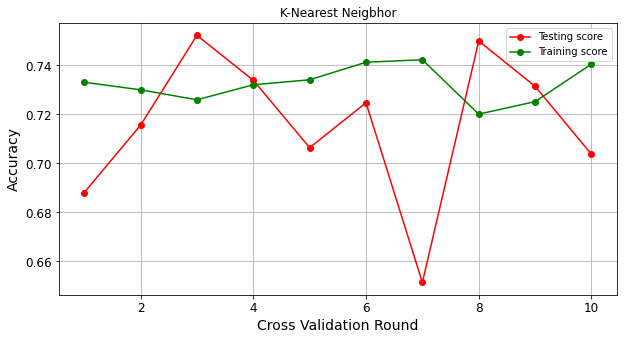

In [47]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
ax.set_title('K-Nearest Neigbhor')
ax.set_xlabel("Cross Validation Round")
ax.set_ylabel("Accuracy")
ax.grid()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.plot(x, accuracy_KNN, 'o-', color="r", label="Testing score")
ax.plot(x, accuracy_KNN_Train, 'o-', color="g", label="Training score")
ax.legend(loc="best")

plt.show()

In [45]:
#Naive Bayes
print(Average(accuracy_NB))

0.7186119605844377


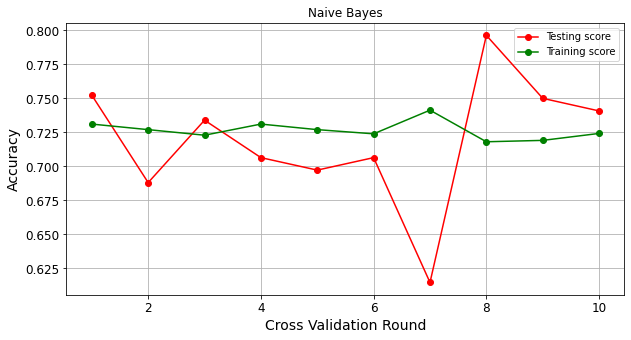

In [48]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
ax.set_title('Naive Bayes')
ax.set_xlabel("Cross Validation Round")
ax.set_ylabel("Accuracy")
ax.grid()

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax.plot(x, accuracy_NB, 'o-', color="r", label="Testing score")
ax.plot(x, accuracy_NB_Train, 'o-', color="g", label="Training score")
ax.legend(loc="best")

plt.show()

### Testing Set

In [49]:
NN_Clf = NeuralNetworkClassifier(X_trainRed, X_testRed, y_trainRed, y_testRed)
y_predict_NN = NN_Clf.predict(X_testRed)
AverageTesting.append(NN_Clf.evaluate(X_testRed, y_testRed,verbose=1))
AverageUnit.append(Average(NN_Clf.fit(X_trainRed, y_trainRed, epochs=100, batch_size=10, verbose=1).history['accuracy']))

Train on 1087 samples
Epoch 1/100
1087/1087 [==============================] - 1s 662us/sample - loss: 0.6462 - accuracy: 0.6348
Epoch 2/100
1087/1087 [==============================] - 0s 151us/sample - loss: 0.5694 - accuracy: 0.7065
Epoch 3/100
1087/1087 [==============================] - 0s 153us/sample - loss: 0.5465 - accuracy: 0.7240
Epoch 4/100
1087/1087 [==============================] - 0s 151us/sample - loss: 0.5369 - accuracy: 0.7387
Epoch 5/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.5319 - accuracy: 0.7406
Epoch 6/100
1087/1087 [==============================] - 0s 155us/sample - loss: 0.5277 - accuracy: 0.7433
Epoch 7/100
1087/1087 [==============================] - 0s 152us/sample - loss: 0.5246 - accuracy: 0.7406
Epoch 8/100
1087/1087 [==============================] - 0s 160us/sample - loss: 0.5234 - accuracy: 0.7424
Epoch 9/100
1087/1087 [==============================] - 0s 160us/sample - loss: 0.5217 - accuracy: 0.7387
Epoch 10/100
10

1087/1087 [==============================] - 0s 147us/sample - loss: 0.4593 - accuracy: 0.7810
Epoch 77/100
1087/1087 [==============================] - 0s 152us/sample - loss: 0.4591 - accuracy: 0.7792
Epoch 78/100
1087/1087 [==============================] - 0s 145us/sample - loss: 0.4580 - accuracy: 0.7764
Epoch 79/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.4565 - accuracy: 0.7820
Epoch 80/100
1087/1087 [==============================] - 0s 157us/sample - loss: 0.4569 - accuracy: 0.7792
Epoch 81/100
1087/1087 [==============================] - 0s 150us/sample - loss: 0.4550 - accuracy: 0.7856
Epoch 82/100
1087/1087 [==============================] - 0s 153us/sample - loss: 0.4549 - accuracy: 0.7774
Epoch 83/100
1087/1087 [==============================] - 0s 146us/sample - loss: 0.4542 - accuracy: 0.7829
Epoch 84/100
1087/1087 [==============================] - 0s 152us/sample - loss: 0.4532 - accuracy: 0.7875
Epoch 85/100
1087/1087 [=================

272/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Train on 1087 samples
Epoch 1/100
1087/1087 [==============================] - 0s 181us/sample - loss: 0.4437 - accuracy: 0.7893
Epoch 2/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.4430 - accuracy: 0.7939
Epoch 3/100
1087/1087 [==============================] - 0s 151us/sample - loss: 0.4424 - accuracy: 0.7893
Epoch 4/100
1087/1087 [==============================] - 0s 147us/sample - loss: 0.4417 - accuracy: 0.7985
Epoch 5/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.4410 - accuracy: 0.7884
Epoch 6/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.4410 - accuracy: 0.7985
Epoch 7/100
1087/1087 [==============================] - 0s 154us/sample - loss: 0.4404 - accuracy: 0.7939
Epoch 8/100
1087/1087 [==============================] - 0s 147us/sample - loss: 0.4405 - accuracy: 0.7921
Epoch 9/100
1087/1087 [==============================] - 0s 155us/sample - loss: 0.4398 - accuracy: 0.7912
Epoch 10/100
10

1087/1087 [==============================] - 0s 154us/sample - loss: 0.4101 - accuracy: 0.8031
Epoch 77/100
1087/1087 [==============================] - 0s 149us/sample - loss: 0.4094 - accuracy: 0.8086
Epoch 78/100
1087/1087 [==============================] - 0s 156us/sample - loss: 0.4101 - accuracy: 0.8114
Epoch 79/100
1087/1087 [==============================] - 0s 150us/sample - loss: 0.4091 - accuracy: 0.8086
Epoch 80/100
1087/1087 [==============================] - 0s 144us/sample - loss: 0.4087 - accuracy: 0.8105
Epoch 81/100
1087/1087 [==============================] - 0s 147us/sample - loss: 0.4081 - accuracy: 0.8059
Epoch 82/100
1087/1087 [==============================] - 0s 149us/sample - loss: 0.4074 - accuracy: 0.8068
Epoch 83/100
1087/1087 [==============================] - 0s 148us/sample - loss: 0.4073 - accuracy: 0.8105
Epoch 84/100
1087/1087 [==============================] - 0s 150us/sample - loss: 0.4074 - accuracy: 0.8105
Epoch 85/100
1087/1087 [=================

In [50]:
#Neural Network Test
accuracies = []
for loss, accuracy in AverageTesting:
    accuracies.append(accuracy)
Average_accuracy = Average(accuracies)
print(Average_accuracy)

0.7325926097956571
